# **Klasifikasi Menggunakan Decision Tree dan KNN (Linear Classification)**

Berikut ini merupakan contoh implementasi klasifikasi dan analisis proses klasifikasi. Pada contoh implementasi ini akan digunakan 2 algoritma umum yang biasanya digunakan untuk melakukan proses klasifikasi yaitu:

*   $Decision Tree$
*   $KNN (K-Nearest Neighbor)$



In [36]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

warnings.filterwarnings('ignore')
%matplotlib inline

## 1 - Load Dataset

Pada implementasi kali ini, digunakan datasets [bank.csv](https://www.kaggle.com/janiobachmann/bank-marketing-dataset) dengan tujuan untuk melakukan klasifikasi terhadap nasabah yang melakukan deposit dan yang tidak melakukan deposit. Jumlah row sebanyak $11162$ dengan $7$ atribut.

### a. Load Dataset

---

In [2]:
def load_dataset():
  !wget 'https://raw.githubusercontent.com/shabri-arrahim/TELKOM_DTI_Multi-Linear-Regression/master/datasets/bank.csv'
  dataset = pd.read_csv('bank.csv', sep=',')

  return dataset

In [3]:
df = load_dataset()
df.head()

--2020-10-30 16:18:35--  https://raw.githubusercontent.com/shabri-arrahim/TELKOM_DTI_Multi-Linear-Regression/master/datasets/bank.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918960 (897K) [text/plain]
Saving to: ‘bank.csv.2’

bank.csv.2          100%[===================>] 897.42K  --.-KB/s    in 0.04s   

2020-10-30 16:18:35 (22.9 MB/s) - ‘bank.csv.2’ saved [918960/918960]



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 2 - Explorasi Data

Pada section ini, akan dilakukan eksplorasi pada dataset untuk mengidentifikasi hal-hal yang dianggap "Anomali" pada dataset seperti $Mising Value$, $Inkonsistensi  Nilai$, $DuplicatValue$ dan untuk melakukan screenig terhadap dataset sebelum dimasukkan kedalam $Model$ yang akan dibangun.

---

### a. Melihat ukuran (**shape**) dari dataset

Pertama, lihat ukuran dataset

In [4]:
df.shape

(11162, 17)

Datasets memiliki jumlah record sebesar $11162$ dan terdapat $17$ atribut.

---

### b. Identifikasi Nilai Duplikat

Kedua, megidentifikasi nilai yang duplikat didalam dataset 

In [5]:
print("Total Data Duplikat Pada Dataset: {}".format(df.duplicated().sum()))

Total Data Duplikat Pada Dataset: 0


Pada datasets tidak terdapat nilai yang duplikat

### c. Identifikasi Missing Value

Ketiga, identifikasi missing value

In [6]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Terlihat bahwa untuk setiap atribut pada datsets tidak terindikasi adanya $Missing Value$

---

### d. Eksplorasi Atribut Bertipe Numerik

Karena pada dataset terdapat atribut yang memiliki tipe data numerik, maka berikut ini akan dilakukan eksplorasi atribut bertipe numerik dengan menggunakan visualisai plot histogram.

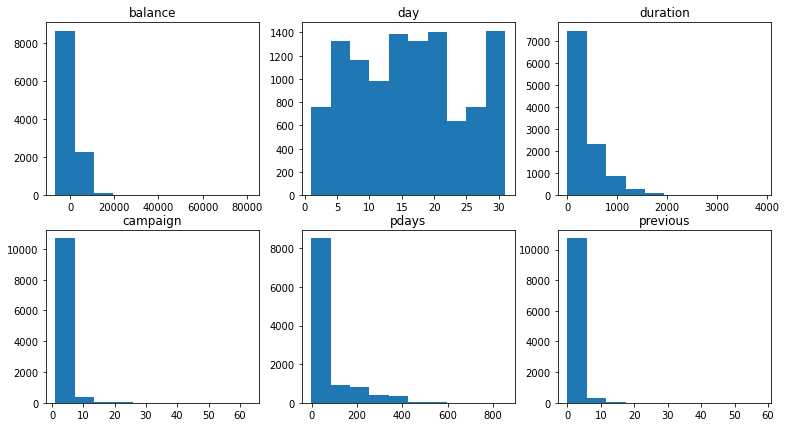

In [7]:
num_column = [col for col in df.select_dtypes(include='int64').columns if col != 'age']
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(13, 7))

counter = 0
for col in num_column:
  x_axis = counter // 3
  y_axis = counter % 3
  
  ax[x_axis, y_axis].hist(df[col])
  ax[x_axis, y_axis].set_title(col)
  
  counter += 1

plt.show()

Terlhat bahwa disetian atribut terdapat outlayer. Untuk lebih jelas lagi mari kita lihat distribusi statistik dari tiap atribut tersebut.

In [8]:
df[num_column].describe()

,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Terlihat bahwa pada atribut '**pdays**' memiliki rata-rata sebesar $51.33$ tetapi $50\%$ dari total record memiliki value $-1$. Karena hal tersebut atribut '**pdays**' dapat di drop dari dataset (Proses drop akan dilakukan pada tahap pre-processing/data cleaning).  

---

### e. Eksplorasi Atribut Bertipe Kategorik (Non-Numerik)

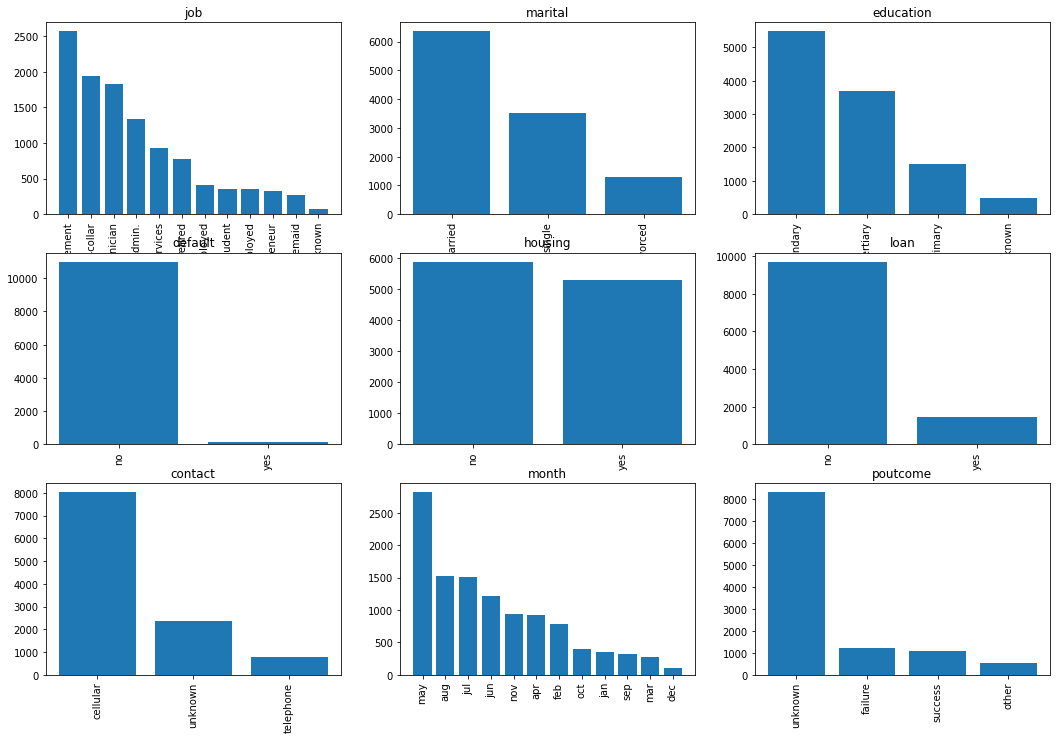

In [9]:
cat_column = [col for col in df.select_dtypes(include='object').columns]
fig, ax = plt.subplots(3, 3, figsize=(18, 12))

counter = 0
for col in cat_column:
  data_freq = pd.DataFrame(df[col].value_counts())
  frequency = data_freq[col].values
  points = data_freq[col].index
  
  x_axis = counter // 3
  y_axis = counter % 3

  try:
    ax[x_axis, y_axis].bar(points, frequency)
    ax[x_axis, y_axis].set_title(col)

    for tick in ax[x_axis, y_axis].get_xticklabels():
      tick.set_rotation(90)
  except:
    pass

  counter += 1

plt.show()

Dari keseluruhan atribut bertipe kategorik, atribut **'default'** dan **'loan'** mengalami distrubusi data yang paling kurang merata untuk masing-masing valuenya dibandingkan atribut lainnya, oleh sebab itu parameter untuk melakukan claim tingkat keakuratan klasifikasi tidak cukup hanya berdasarkan nilai akurasi saja.

---

### f. Analisa Korelasi (Pearson Correlations)

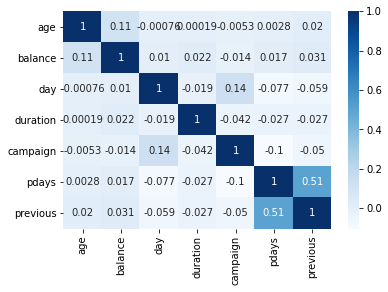

In [10]:
sns.heatmap(df.corr(method='pearson'), cmap='Blues', annot=True)

---

### g. Analisis Komposisi Nilai Target (label)

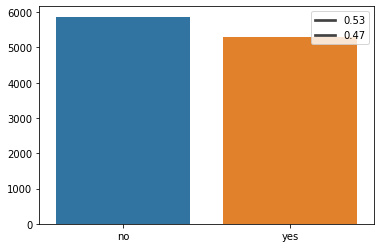

In [11]:
dep_freq = df.deposit.value_counts()

sns.barplot(x=dep_freq.index, y=dep_freq.values).legend(labels=round(df.deposit.value_counts()/df.deposit.count(), 2))

Terlihat bahwa distribusi data target masih tergolong normal karena selisih antara kelas "yes" dan "no" masih tergolong kecil.

---

## 3 - Pra-Proses

Pada tahap pra-proses umumnya ada 3 hal yang harus dilakukan diantaranya:


*   **Data Cleaning** : menghilangkan noise,missing, dan data yang tidak konsisten.
*   **Data Integration** : menggabungkan data darisumber yang berbeda dan menyimpan data yang koheren
*   **Data Transformation** : meningkatkan akurasidan efisiensi penggalian data (normalisasi)
*   **Data Reduction** : mereduksi ukuran data danmengeliminasi redudansi

Pada implentasi kali ini proses **Data Cleaning** tidak dilakukan karena telah diketahui di tahap explorasi data, dataset yang kita miliki tidak terdapat **missing value** dan proses **Data Integration** tidak perlu dilakukan.


---

### a. Data Reduction
Drop atribut **'pdays'** dari dataset

In [12]:
# Drop atribut 'pdays' dari dataset
df = df.drop('pdays', axis=1)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,0,unknown,yes


---

### b. Data Transformation


*   Nilai data target (deposit) di encode menjadi $1$ untuk $yes$ dan $0$ untuk $no$ 
*   Atribut yang bertipe kategorik di convert menjadi data **One-Hot-Encoder**





In [13]:
encoder = LabelEncoder()
# Nilai data target (deposit) di encode menjadi  1  untuk  yes  dan  0  untuk  no
df['deposit'] = encoder.fit_transform(df.deposit.values) 
# Atribut yang bertipe kategorik di convert menjadi data One-Hot-Encoder
df = pd.get_dummies(df)

df.head()

,age,balance,day,duration,campaign,previous,deposit,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1042,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,56,45,5,1467,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,41,1270,5,1389,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,55,2476,5,579,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,54,184,5,673,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


---

### c. Extraksi Fitur, Pembagian Data Train dan Test 

In [14]:
fitur = df.drop('deposit', axis=1)
target = df.deposit.values

Besar data tes adalah $30\%$ dari total dataset dengan besaran acak sebesar $45$ 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(fitur, target, test_size=0.3, random_state=45)

---

## 4 - Build Model

---

### a. Model 1 [Decision Tree]

Pada model ini proses classifikasi menggunakan algoritma Decision Tree dengan menggunakan K-Fold Cross Validation untuk meningkatkan akurasi model.

**Define library yang diperlukan**

In [16]:
import pydotplus

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

**Fungsi untuk mencari nilai kedalaman tree yang menghasilkan akurasi tinggi pada data train menggunakan cross-validation**

In [17]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    
    return cv_scores_mean, cv_scores_std, accuracy_scores

**Fungsi visualisasi terhadap hasil cross-validation**

In [18]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='Rerata akurasi cross-validation', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='Train Akurasi', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Kedalaman Tree', fontsize=14)
    ax.set_ylabel('Akurasi', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

**Fungsi untuk training and evaluasi tree**

In [19]:
def run_single_tree(X_train, y_train, X_test, y_test, depth):
    model = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    print('Kedalaman tree : ', depth)
    print('Akurasi, Training Set: ', round(accuracy_train*100,5), '%')
    print('Akurasi, Test Set: ', round(accuracy_test*100,5), '%')
    return model, accuracy_train, accuracy_test

Menyesuaikan model trees dengan kedalaman 1 sampai 24

In [20]:
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

Visualisasi nilai akurasi

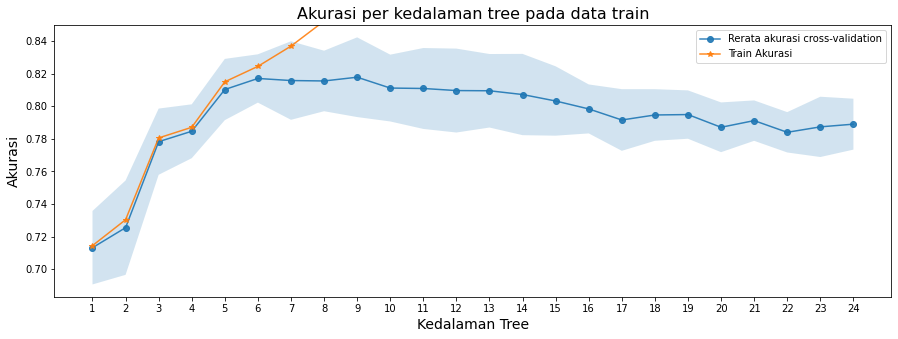

In [21]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Akurasi per kedalaman tree pada data train')

In [22]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('Kedalaman tree-{} memperoleh rerata akurasi cross-validation terbaik dengan {} +/- {}% pada data train'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,3), round(sm_best_tree_cv_score_std*100, 3)))

Kedalaman tree-9 memperoleh rerata akurasi cross-validation terbaik dengan 81.774 +/- 1.222% pada data train


Melakukan evaluate dengan kedalaman Tree $9$

In [30]:
sm_tree_model, sm_best_tree_accuracy_train, sm_best_tree_accuracy_test = run_single_tree(X_train, y_train, X_test, y_test, sm_best_tree_depth)

Kedalaman tree :  9
Akurasi, Training Set:  86.93204 %
Akurasi, Test Set:  81.72589 %


In [24]:
y_preds = sm_tree_model.predict(X_test)
print("Classification Report : \n", classification_report(y_preds, y_test))

Classification Report : 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1668
           1       0.84      0.79      0.81      1681

    accuracy                           0.82      3349
   macro avg       0.82      0.82      0.82      3349
weighted avg       0.82      0.82      0.82      3349



Visualisasi tree yang terbentuk

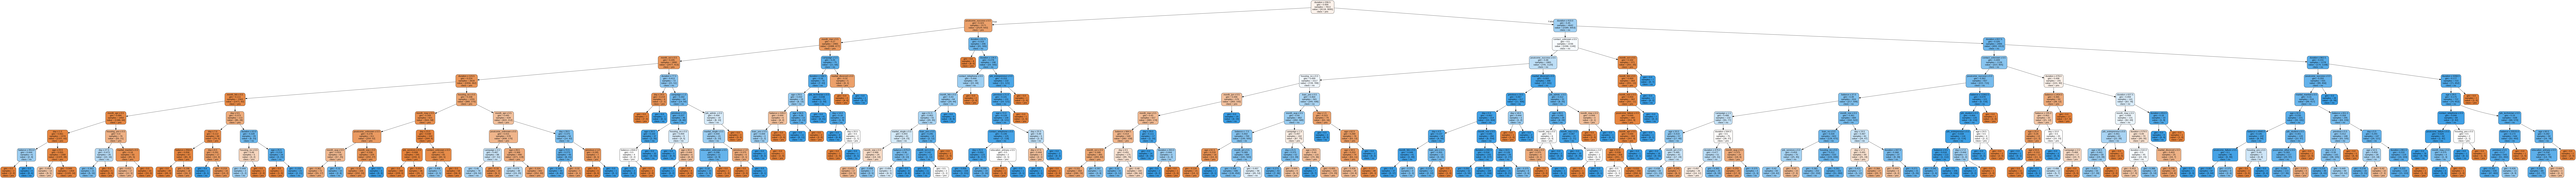

In [25]:
dot_data = StringIO()
export_graphviz(sm_tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                class_names=['yes', 'no'],
                feature_names=[col for col in fitur])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ROC Curve

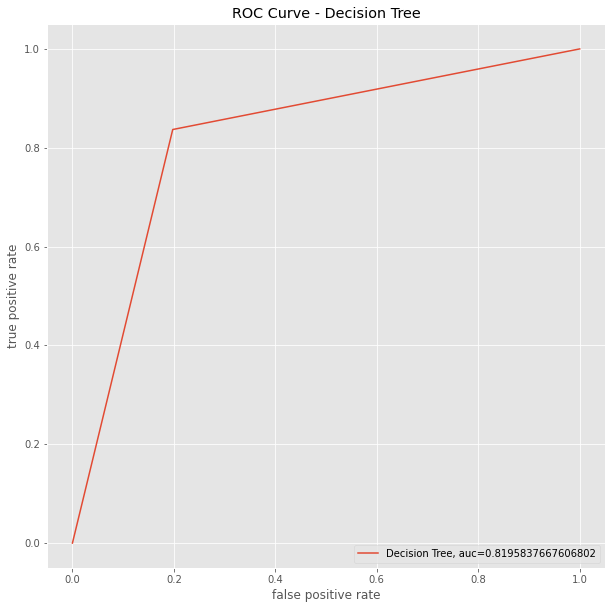

In [38]:
# Set Size and Style
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Visualize ROC Curve
fprtree, tprtree, _ = metrics.roc_curve(y_test,  y_preds)
auctree = metrics.roc_auc_score(y_test, y_preds)
plt.plot(fprtree,tprtree,label="Decision Tree, auc="+str(auctree))
plt.title('ROC Curve - Decision Tree')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

---

### b. Model 2 [KNN]

Pada model ini proses classifikasi menggunakan algoritma KNN dan menggunakan data Validasi untuk meningkatkan akurasi model.

In [26]:
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap

**K-Nearest Neighbor class**

In [27]:
class KNearestNeighbor(object):

    def __init__(self, x, y):
        self.x_train = x
        self.y_train = y


    def predict(self, x, k, distance='euclidean'):
        num_test = x.shape[0]
        num_train = self.x_train.shape[0]
        dists = np.zeros((num_test, num_train))
        if distance == 'euclidean':
            dists = cdist(x, self.x_train)
        elif distance == 'manhattan':
            dists = cdist(x, self.x_train, metric='cityblock')
        else:
            pass
        
        return self.__predict_labels(dists, k=k)

    def __predict_labels(self, dists, k):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []      # list dengan lebar k berisi label dari
                                # sebanyak k-tetangga terdekat terhadap data uji ke-i
            closest_y = [self.y_train[idx] for idx in np.argsort(dists[i])[:k]]

            labels = []
            count = []
            count_index = -1
            prev = -1
            for j in np.sort(closest_y):
                if j != prev:
                    count.append(1)
                    count_index += 1
                    prev = j
                    labels.append(j)
                else:
                    count[count_index] += 1
            y_pred[i] = labels[np.argmax(count)]

        return y_pred

Proses Train Model

In [32]:
k_tries = [3, 5, 7, 9, 11, 13]

# Definisi data validasi
val_slice = int(X_train.shape[0]*.9)
X_tr = X_train.iloc[:val_slice, :]
y_tr = y_train[:val_slice]
X_val = X_train.iloc[val_slice:, :]
y_val = y_train[val_slice:]

knn_val = KNearestNeighbor(X_tr, y_tr)

acc_list = []
for k in k_tries:
    acc = accuracy_score(y_val, knn_val.predict(X_val, k=k))
    acc_list.append(acc)
    
    
id_k = np.argmax(acc_list)
print('Jumlah k terbaik adalah ',k_tries[id_k], ', dengan akurasi= {0:.2f}%'.format(acc_list[id_k]*100))

Jumlah k terbaik adalah  11 , dengan akurasi= 71.36%


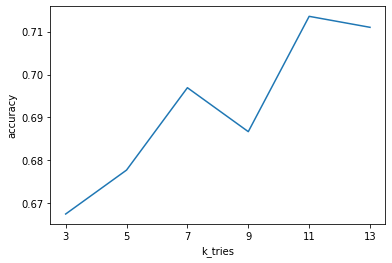

In [33]:
plt.plot(acc_list)
plt.ylabel('accuracy')
plt.xlabel('k_tries')
plt.xticks(np.arange(len(k_tries)), k_tries)
plt.show()

Berdasarkan hasil visualisasi diatas, jumlah $K$ terbaik untuk untuk model terhadap dataset adalah $11$, dengan akurasi data validasi adalh sebesar $71.36\%$

In [35]:
preds_y = knn_val.predict(X_test, k=11)
print("Classification Report : \n", classification_report(preds_y, y_test))

Classification Report : 
               precision    recall  f1-score   support

         0.0       0.74      0.73      0.74      1799
         1.0       0.69      0.71      0.70      1550

    accuracy                           0.72      3349
   macro avg       0.72      0.72      0.72      3349
weighted avg       0.72      0.72      0.72      3349



ROC Curve

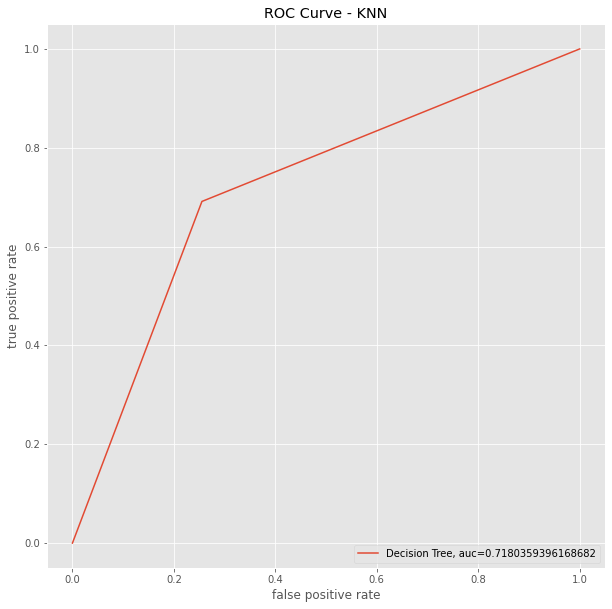

In [40]:
# Set Size and Style
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Visualize ROC Curve
fprknn, tprknn, _ = metrics.roc_curve(y_test,  preds_y)
aucknn = metrics.roc_auc_score(y_test, preds_y)
plt.plot(fprknn,tprknn,label="Decision Tree, auc="+str(aucknn))
plt.title('ROC Curve - KNN')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

---

## 5 - Komparasi Model

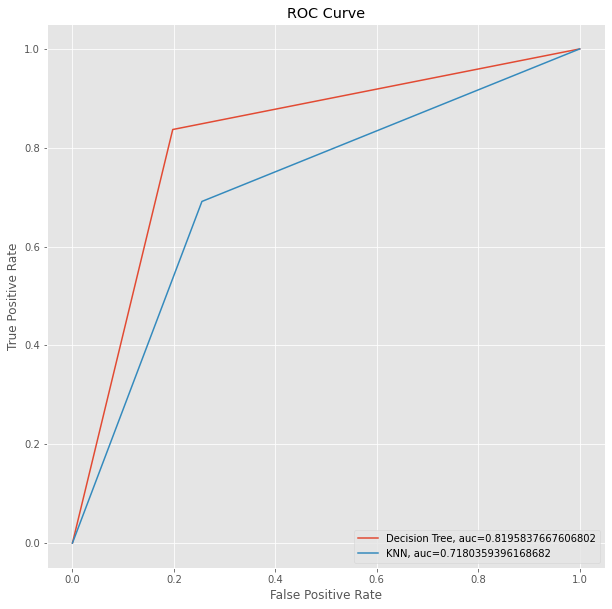

In [41]:
# Comparing ROC Curve
plt.plot(fprtree,tprtree,label="Decision Tree, auc="+str(auctree))
plt.plot(fprknn,tprknn,label="KNN, auc="+str(aucknn))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

Hasil visualisai $ROC$ yang menunjukkan bahwa algoritma klasifikasi $Decision Tree$ lebih unggul dibandingkan dengan algoritma klasifikasi $KNN$

---

# **Kesimpulan**

Berdasarkan hasil implementasi diatas, algoritma yang dapat melakukan klasifikasi yang cukup baik adalah algoritma $Decision Tree$ dengan skor akurasi sebesar $81.72\%$ pada test set dan dibuktikan juga dengan hasil visualisai $ROC$ yang menunjukkan bahwa algoritma klasifikasi $Decision Tree$ lebih unggul dibandingkan dengan algoritma klasifikasi $KNN$.
